## Intersectional Analysis (Gender × Ethnicity) at K=7

This notebook analyzes **intersectional representation** in model shortlists by combining ethnicity and gender into a single group label (e.g., `western_european|male`). We focus on **Top-7** rankings and compare observed group shares against an idealized **uniform target**.

Because the candidate pool is constructed to be balanced across **6 ethnicities × 2 genders = 12 intersectional groups**, the expected share under perfect proportional allocation is:

$$
\text{target share} = \frac{1}{12}
$$

We report each group’s deviation from this target. Positive values indicate over-representation; negative values indicate under-representation.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import re

In [2]:
K = 7

BASE_DIR = "./similarity_matching_output"

models_dict = {
    "fair_lora": "Fair LoRA Adapter",
    "jb_v2": "JobBERT v2",
    "jb_v3": "JobBERT v3",
    "minilm_base": "MiniLM Job Matcher",
    "openai": "openAI Text embedding"
}
eths_dict = {
    "african": "African",
    "western_european": "Western European",
    "arabic_middle_eastern": "Arabic Middle Eastern",
    "south_asian": "South Asian",
    "east_southeast_asian": "East / Southeast Asian",
    "hispanic_latin_american": "Hisanic / Latin American"
}

### Helper utilities: model name parsing + intersectional summary

This section defines two helpers:

**1) `extract_model_name(path)`**  
Extracts the model folder name from paths like `.../similarity_matching_output/<model>/top10_all_jobs.csv`.

**2) `model_intersectional_summary(frame, group_cols=None)`**  
Computes intersectional representation statistics:

- If `group_cols=None`: returns the **overall** distribution across all jobs.
- If `group_cols` is provided (e.g., `["job_domain"]` or `["job_level"]`): returns the distribution **within each slice**.

For slice-wise summaries, the target share is fixed to \(1/12\) to reflect the experimental design (balanced 12 intersectional groups).

In [3]:
def extract_model_name(s):
    s = re.sub(r"/+", "/", s)
    s = re.sub(r"\\+", "/", s)
    s = s.rstrip("/")
    parts = [p for p in s.split("/") if p]
    return parts[-2]
    
def model_intersectional_summary(frame, group_cols=None):
    """
    Computes intersectional representation at K for the provided subset.
    If group_cols is provided (e.g., ["job_domain"]), it computes within each slice.
    """
    if group_cols is None:
        total_slots = len(frame)  # should be jobs * K
        out = (
            frame.groupby("group")
                 .size()
                 .rename("count")
                 .reset_index()
        )
        out["share"] = out["count"] / total_slots
        out["target_share"] = 1.0 / out["group"].nunique()  # should be 1/12 ideally
        out["diff_from_target"] = out["share"] - out["target_share"]
        out = out.sort_values(["share"], ascending=False).reset_index(drop=True)
        return out

    # Slice-wise (e.g., by domain, level)
    counts = (
        frame.groupby(group_cols + ["group"])
             .size()
             .rename("count")
             .reset_index()
    )
    totals = (
        frame.groupby(group_cols)
             .size()
             .rename("total_slots")
             .reset_index()
    )
    out = counts.merge(totals, on=group_cols, how="left")
    out["share"] = out["count"] / out["total_slots"]

    # Use a fixed 12-group target if your design always includes all 12 groups;
    # otherwise it will adapt per-slice based on observed groups.
    # If you ALWAYS have 6 ethnicities x 2 genders for every slice, set target_share=1/12 explicitly.
    out["target_share"] = 1.0 / 12.0
    out["diff_from_target"] = out["share"] - out["target_share"]

    out = out.sort_values(group_cols + ["share"], ascending=[True] * len(group_cols) + [False]).reset_index(drop=True)
    return out

### Step 1: Build Top-7 intersectional summaries per model

For each model’s `top10_all_jobs.csv`:
- filter to `rank <= 7`
- create the intersectional label `group = ethnicity|gender`
- compute an overall distribution at Top-7
- compute slice-wise distributions by:
  - job domain (`job_domain`)
  - job seniority level (`job_level`)

Each run writes three CSVs back into the model’s output folder:

- `intersectional_overall_k7.csv`
- `intersectional_by_domain_k7.csv`
- `intersectional_by_level_k7.csv`

The console output prints a quick disparity summary:
- most over-represented group
- most under-represented group
- max gap between them (over − under)

In [4]:
def intersectional_topk_analysis(csv_path):
    base_model = extract_model_name(csv_path)
    df = pd.read_csv(csv_path)
    topk = (df[df["rank"] <= K].copy())
    
    # Intersectional group label: e.g., "Western European|Female"
    topk["group"] = topk["ethnicity"] + "|" + topk["gender"]
    
    # Overall intersectional distribution at K=7
    overall = model_intersectional_summary(topk)
    
    # Quick disparity summaries
    overall_max_over = overall.loc[overall["diff_from_target"].idxmax()]
    overall_max_under = overall.loc[overall["diff_from_target"].idxmin()]
    overall_max_gap = overall_max_over["diff_from_target"] - overall_max_under["diff_from_target"]

    print(f"\n Summary intersectional representation at K=7 ({base_model})")
    print("\n=== Overall disparity summary (vs uniform 1/12) ===")
    print(f"Most overrepresented:  {overall_max_over['group']}  diff={overall_max_over['diff_from_target']:.4f}  share={overall_max_over['share']:.4f}")
    print(f"Most underrepresented: {overall_max_under['group']}  diff={overall_max_under['diff_from_target']:.4f}  share={overall_max_under['share']:.4f}")
    print(f"Max gap (over - under): {overall_max_gap:.4f} \n")
    print("*" * 70)
    
    # Breakdown by job domain and level (optional but usually useful)
    by_domain = model_intersectional_summary(topk, group_cols=["job_domain"])
    by_level  = model_intersectional_summary(topk, group_cols=["job_level"])

    overall.to_csv(os.path.join(BASE_DIR, base_model, f"intersectional_overall_k{K}.csv"), index=False)
    by_domain.to_csv(os.path.join(BASE_DIR, base_model, f"intersectional_by_domain_k{K}.csv"), index=False)
    by_level.to_csv(os.path.join(BASE_DIR, base_model, f"intersectional_by_level_k{K}.csv"), index=False)

### Execute across all models

This cell searches for every `*/top10_all_jobs.csv` under `similarity_matching_output/` and runs the intersectional analysis for each model. After it finishes, each model folder should contain the three intersectional output files described above.

In [5]:
pattern = os.path.join(BASE_DIR, "*/top10_all_jobs.csv")
files = sorted(glob.glob(pattern))

for f in files:
    intersectional_topk_analysis(f)


 Summary intersectional representation at K=7 (fair_lora)

=== Overall disparity summary (vs uniform 1/12) ===
Most overrepresented:  east_southeast_asian|male  diff=0.0833  share=0.1667
Most underrepresented: hispanic_latin_american|male  diff=-0.0357  share=0.0476
Max gap (over - under): 0.1190 

**********************************************************************

 Summary intersectional representation at K=7 (jb_v2)

=== Overall disparity summary (vs uniform 1/12) ===
Most overrepresented:  western_european|male  diff=0.2312  share=0.3145
Most underrepresented: hispanic_latin_american|male  diff=-0.0675  share=0.0159
Max gap (over - under): 0.2986 

**********************************************************************

 Summary intersectional representation at K=7 (jb_v3)

=== Overall disparity summary (vs uniform 1/12) ===
Most overrepresented:  african|female  diff=0.0804  share=0.1637
Most underrepresented: hispanic_latin_american|male  diff=-0.0575  share=0.0258
Max gap (ov

## Visualizing intersectional disparities (Overall at \(K=7\))

Next, we visualize deviations from proportional allocation using heatmaps.

The plotted value is **deviation percentage**:

$$
100 \times \text{diff\_from\_target}
$$

So a value of `+10%` means the group appears 10 percentage points *more* than the uniform target share (\(1/12 \approx 8.33\%\)), and `-10%` means 10 percentage points less.

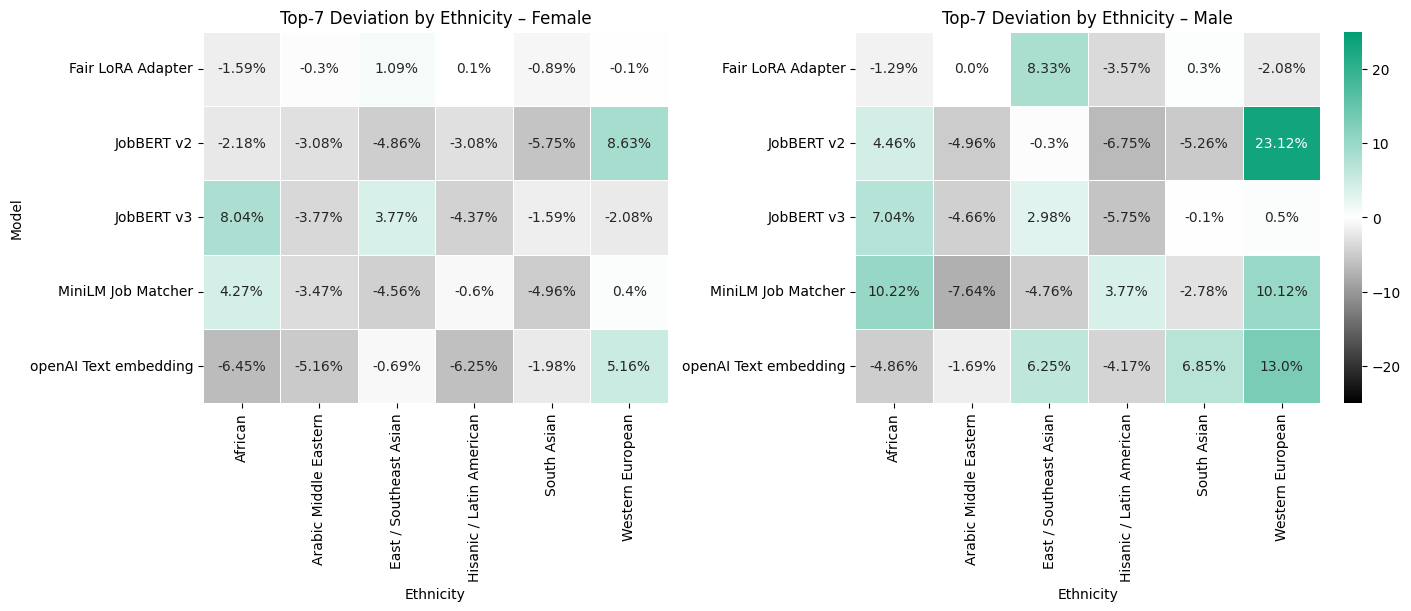

In [6]:
def plot_maps_male_v_female():
    PATTERN = "*/intersectional_overall_k7.csv"
    VMAX = 25
    
    csv_paths = sorted(glob.glob(os.path.join(BASE_DIR, PATTERN)))
    if not csv_paths:
        raise FileNotFoundError(f"No files found for pattern: {os.path.join(BASE_DIR, PATTERN)}")
    
    rows = []
    for p in csv_paths:
        model = models_dict[extract_model_name(p)]
        df = pd.read_csv(p)
        df[["ethnicity", "gender"]] = df["group"].str.split(r"\|", expand=True)
        df["ethnicity"] = df["ethnicity"].apply(lambda x: eths_dict[x])
        df["model"] = model
        rows.append(df[["model", "ethnicity", "gender", "diff_from_target"]])
    
    all_df = pd.concat(rows, ignore_index=True)
    
    model_order = [models_dict[extract_model_name(p)] for p in csv_paths]
    all_df["model"] = pd.Categorical(all_df["model"], categories=model_order, ordered=True)
        
    # Build the two matrices: (models x ethnicities)
    female_mat = (
        all_df[all_df["gender"].str.lower() == "female"]
        .pivot(index="model", columns="ethnicity", values="diff_from_target")
    )
    female_mat = (female_mat * 100).round(2)
    
    male_mat = (
        all_df[all_df["gender"].str.lower() == "male"]
        .pivot(index="model", columns="ethnicity", values="diff_from_target")
    )
    male_mat = (male_mat * 100).round(2)
    
    common_cols = sorted(set(female_mat.columns) | set(male_mat.columns))
    female_mat = female_mat.reindex(columns=common_cols)
    male_mat = male_mat.reindex(columns=common_cols)
    
    # Annotation labels
    female_labels = female_mat.astype(str) + "%"
    male_labels   = male_mat.astype(str) + "%"
    
    # ----------------------------
    # Plot: two big heatmaps (Female / Male)
    # ----------------------------
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
    
    cmap = sns.color_palette("blend:#000000,#fff,#009E73", as_cmap=True)
    
    # Females
    hm_f = sns.heatmap(
        female_mat,
        ax=axes[0],
        cmap=cmap,
        center=0,
        vmin=-VMAX,
        vmax=VMAX,
        linewidths=0.5,
        annot=female_labels,
        fmt="",
        cbar=False,
        cbar_kws={"label": "Deviation from proportional allocation"}
    )
    axes[0].set_title("Top-7 Deviation by Ethnicity – Female")
    axes[0].set_xlabel("Ethnicity")
    axes[0].set_ylabel("Model")
    axes[0].tick_params(axis="x", rotation=90)
    axes[0].tick_params(axis="y", rotation=0)
    
    # Males (no separate colorbar; reuse same scale)
    hm_m = sns.heatmap(
        male_mat,
        ax=axes[1],
        cmap=cmap,
        center=0,
        vmin=-VMAX,
        vmax=VMAX,
        linewidths=0.5,
        annot=male_labels,
        fmt="",
        cbar=True
    )
    axes[1].set_title("Top-7 Deviation by Ethnicity – Male")
    axes[1].set_xlabel("Ethnicity")
    axes[1].set_ylabel("")
    axes[1].tick_params(axis="x", rotation=90)
    axes[1].tick_params(axis="y", rotation=0)
    
    plt.show()

plot_maps_male_v_female()

---

### Gender tilt heatmap (Male − Female) by ethnicity and model

This visualization collapses the two gender panels into a single interpretable statistic:

$$
\text{tilt} = \text{diff\_from\_target}_{\text{male}} - \text{diff\_from\_target}_{\text{female}}
$$

Interpretation:
- `tilt ≈ 0` → roughly balanced male vs female deviation for that ethnicity
- `tilt > 0` → more male-leaning (male group is more over-represented / less under-represented)
- `tilt < 0` → more female-leaning

Values are shown in percentage points for readability.

C:\Users\IuG_Lap1\AppData\Local\Temp\ipykernel_15552\705074845.py:30: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = all_df.pivot_table(


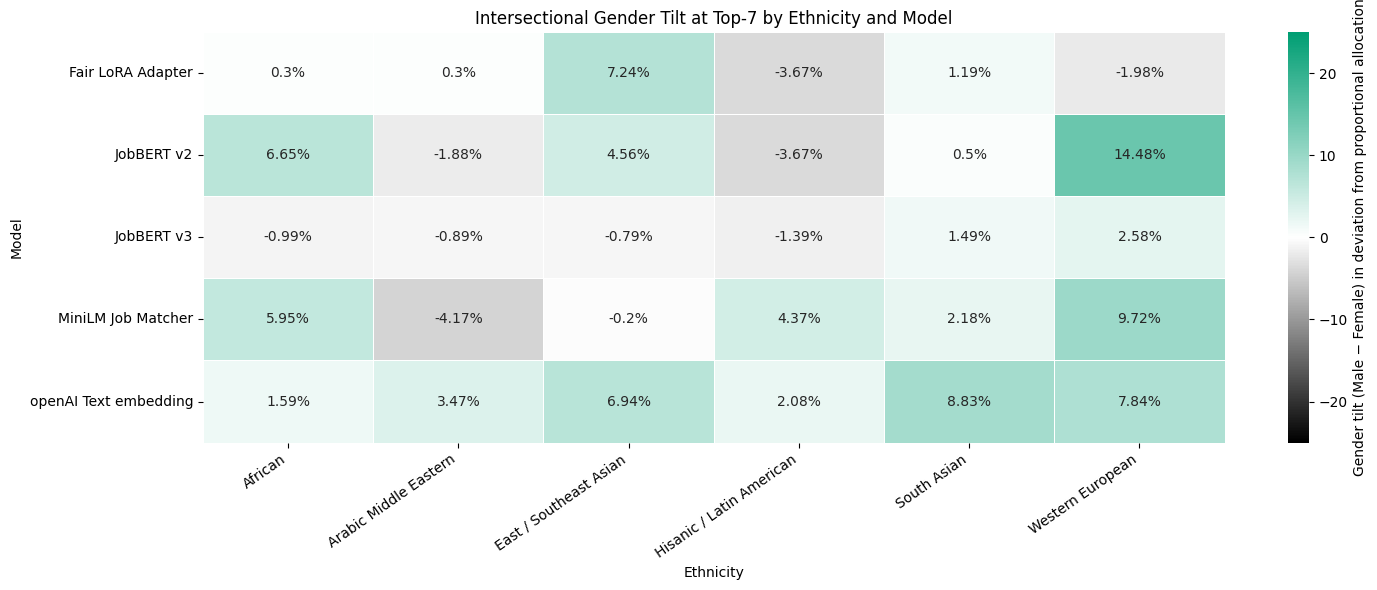

In [10]:
def plot_maps_eth_v_models():
    PATTERN = "*/intersectional_overall_k7.csv"  
    VMAX = 25
    
    csv_paths = sorted(glob.glob(os.path.join(BASE_DIR, PATTERN)))
    if not csv_paths:
        raise FileNotFoundError(f"No files found for pattern: {os.path.join(BASE_DIR, PATTERN)}")
    
    model_order = [models_dict[extract_model_name(p)] for p in csv_paths]
    
    rows = []
    for p in csv_paths:
        model = models_dict[extract_model_name(p)]
        df = pd.read_csv(p)
        df[["ethnicity", "gender"]] = df["group"].str.split(r"\|", expand=True)
        df["ethnicity"] = df["ethnicity"].apply(lambda x: eths_dict[x])
        df["model"] = model
        rows.append(df[["model", "ethnicity", "gender", "diff_from_target"]])
    
    all_df = pd.concat(rows, ignore_index=True)
    all_df["model"] = pd.Categorical(all_df["model"], categories=model_order, ordered=True)
    
    # ----------------------------
    # Compute "gender tilt" per (model, ethnicity)
    # tilt = male deviation - female deviation
    #   = 0   => balanced
    #   > 0   => more male-leaning
    #   < 0   => more female-leaning
    # ----------------------------
    wide = all_df.pivot_table(
        index=["model", "ethnicity"],
        columns="gender",
        values="diff_from_target",
        aggfunc="mean"
    ).reset_index()
    
    wide["tilt_male_minus_female"] = wide.get("male", 0.0) - wide.get("female", 0.0)
    
    heatmap_values = wide.pivot(
        index="model",
        columns="ethnicity",
        values="tilt_male_minus_female"
    )
    heatmap_values = (heatmap_values * 100).round(2)

    heatmap_labels = heatmap_values.astype(str) + "%"
    
    plt.figure(figsize=(15, 6))
    
    sns.heatmap(
        heatmap_values,
        cmap=sns.color_palette("blend:#000000,#fff,#009E73", as_cmap=True),  # blue->white->red
        center=0,
        vmin=-VMAX,
        vmax=VMAX,
        linewidths=0.5,
        annot=heatmap_labels,
        fmt="",
        cbar_kws={"label": "Gender tilt (Male − Female) in deviation from proportional allocation"}
    )
    
    plt.title("Intersectional Gender Tilt at Top-7 by Ethnicity and Model")
    plt.xlabel("Ethnicity")
    plt.ylabel("Model")
    plt.xticks(rotation=35, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_maps_eth_v_models()